In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 



Declare the model that we have already detected as the best model to fine tune

In [2]:
model = MLPRegressor()

In [3]:
def get_data_separated(dataframe, test_size=0.2, random_state=None):
    target_feature = ['ΔVC -p'] #+ ΔVC-m,ΔVC -p
    features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','ΔVC-m','cid']

    # Assuming 'target_feature' is the dependent variable (y)
    y = dataframe[target_feature]
    X = dataframe.drop(columns=features_to_drop + target_feature)
    X =X.fillna(0)

    # Split into training and testing sets, excluding data_val
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    # create the next sets , you split the temp data into halfs 
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def scaling_data(X_train,X_val,X_test):

    scaler = StandardScaler()

    scaler.fit(X_train)
    
    # filename = '../models/scaler_for_all_features.sav'
    # pickle.dump(scaler, open(filename, 'wb'))
    
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_val = scaler.transform(X_val)
    return scaled_train,scaled_val,scaled_test

Get the data in place and split it 

In [5]:
rng = np.random.RandomState(42)
# data loading 
path = '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/data/pubchem_data_2023-12-05_343_samples.csv'
df_all_data = pd.read_csv(path)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_separated(df_all_data,random_state=rng)
X_train, X_val, X_test = scaling_data(X_train, X_val, X_test)

Params to make a search. This will make a long search for grid search thus we are using hyperband search 

In [7]:
params = {
    "hidden_layer_sizes": [
        (2400, ),
        (1200, 1200),
        (600, 600, 600, 600),
        (400, 400, 400, 400, 400, 400),
        (1200, 600, 300, 300),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
    "solver":["sgd","adam"],
    "learning_rate":["constant", "invscaling", "adaptive"]
}

For the use of Hyperband search , we need to use a libray called Dask, to distribute the computation , and make thinks super fast. The trick with Hyoperband search is that the model you are gointo to fine tune need to accept partial_fit, in the case of MLP and SGD they both accept this . But be careful some solver are not accepting as partial_fit is only available for stochastic optimizers. lbfgs (a solver) is not stochastic. 

In [8]:
from dask_ml.model_selection import HyperbandSearchCV

In [9]:
n_examples = 15 * len(X_train)
n_params = 15

In [10]:
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees

max_iter, chunks

(15, 380)

In [11]:
import dask.array as da
X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train.to_numpy().ravel(), chunks=chunks)
X_train2

dask.array<array, shape=(380, 37), dtype=float64, chunksize=(380, 37), chunktype=numpy.ndarray>

We need to declare a Client to manage the computation; in my laptop I want to run multiprocessing (M1 chip). Thus 1 thread per worker, I have 8 free processors = 8 workers 

In [12]:
from distributed import Client
client = Client(processes=True, threads_per_worker=1,
                n_workers=8, memory_limit='2GB')
client

2024-03-04 12:38:24,722 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/notebooks/dask-worker-space/worker-x7c22xw2', purging
2024-03-04 12:38:24,723 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/notebooks/dask-worker-space/worker-msbj1b14', purging
2024-03-04 12:38:24,725 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/notebooks/dask-worker-space/worker-sxcuqq53', purging
2024-03-04 12:38:24,727 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/notebooks/dask-worker-space/worker-k5xu3ete', purging
2024-03-04 12:38:24,729 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/notebooks/dask-worker-sp

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52489,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:52519,Total threads: 1
Dashboard: http://127.0.0.1:52527/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:52496,


This here pass the parameters to the algorithm of the search , and a couple more intructions 

In [13]:
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,random_state=rng 
)

This is specific of the Hyperband to indicate how munch computation is done. it will pass to the workers the max_iter and chunks they need to compute. This shows how many partial_fit calls will be performed in the computation. metadata also includes information on the number of models created.

In [14]:
search.metadata["partial_fit_calls"]


101

This perfrom the search , in this case maybe < 1 minute

In [15]:
%%time
search.fit(X_train2, y_train2)

/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/env

CPU times: user 1.52 s, sys: 406 ms, total: 1.93 s
Wall time: 13 s


/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/dask_ml/model_selection/_hyperband.py:455: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cv_results = {k: np.array(v) for k, v in cv_results.items()}


HyperbandSearchCV(estimator=MLPRegressor(), max_iter=15,
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1.10164595e-06, 1.1...
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(2400,), (1200, 1200),
                                                     (600, 600, 600, 600),
                                                     (400, 400, 400, 400, 400,
                                                      400),
                                                     (1200, 600, 300, 300)],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'solver': ['sgd', 'adam']},
                  patience=True,
                  random_state=RandomState(MT19937) at 0x17EC25D40)

According to the internal test size of the MPL (which is formally the validation test) you can retrive a score . In this case this score is the R^2, however we could modify the metric to use using the parameters specification. 

In [16]:
search.best_score_


0.8907343628425515

Here we can see the specificts of the best model found from the search 

In [17]:
search.best_estimator_


MLPRegressor(alpha=1.5037553212997384e-06, batch_size=64,
             hidden_layer_sizes=(1200, 1200), learning_rate='invscaling')

And we can see all the history of the search and make a judgement about the models looking at the internal metrics 

In [18]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by="test_score", ascending=False).head()

,model_id,params,param_alpha,param_hidden_layer_sizes,std_score_time,mean_partial_fit_time,mean_score_time,partial_fit_calls,std_partial_fit_time,param_batch_size,param_activation,param_learning_rate,rank_test_score,bracket,param_solver,test_score
11,bracket=1-2,"{'solver': 'adam', 'learning_rate': 'invscalin...",0.000002,"(1200, 1200)",0.004585,0.244788,0.022846,15,0.082383,64,relu,invscaling,1,1,adam,0.890734
14,bracket=0-0,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.000933,"(1200, 1200)",0.003553,0.760257,0.011723,11,0.318586,16,relu,adaptive,1,0,adam,0.869295
4,bracket=2-4,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.000011,"(2400,)",0.005196,0.271112,0.008438,9,0.112446,16,relu,adaptive,1,2,adam,0.853692
12,bracket=1-3,"{'solver': 'adam', 'learning_rate': 'constant'...",0.000112,"(1200, 600, 300, 300)",0.004831,1.174830,0.033456,5,0.500113,16,tanh,constant,2,1,adam,0.774039
6,bracket=2-6,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.000011,"(1200, 1200)",0.002123,0.381146,0.026650,3,0.046056,64,tanh,constant,2,2,sgd,0.768646


We can calulate directyl the metric of score using the model like this 

In [19]:
search.score(X_test, y_test)


0.9403414918689378

or evaluate all at once 

In [20]:
from sklearn.metrics import r2_score , mean_absolute_error, mean_squared_error , mean_absolute_percentage_error, median_absolute_error

def save_metrics_results(model,X_test,y_test,tag):

    y_pred = model.predict(X_test)
    r2 = r2_score(y_pred=y_pred,y_true=y_test)
    MAE = mean_absolute_error(y_pred=y_pred,y_true=y_test) 
    MSE = mean_squared_error(y_pred=y_pred,y_true=y_test) 
    MAPE = mean_absolute_percentage_error(y_pred=y_pred,y_true=y_test)
    MedAE = median_absolute_error(y_pred=y_pred,y_true=y_test)

    results = {
        "R^2": r2,
        "MAE":MAE,
        "MSE":MSE,
        "MAPE":MAPE ,
        "MedAE":MedAE,
    }
    mean_df = pd.DataFrame(data=results,index=[f"{tag}"])
    return mean_df

In [21]:
save_metrics_results( y_test= y_test, X_test = X_test, model = search.best_estimator_, tag="Best model")

,R^2,MAE,MSE,MAPE,MedAE
Best model,0.940341,1.544013,4.743082,0.521695,1.267625


Or we can be more visual and look again to the plot of R^2

In [22]:
def plot_the_r2(y_true, X_pred , model): #(model,X_test,y_test,tag)
    y_true = y_true.to_numpy().ravel()
    y_pred = model.predict(X_pred)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')
    plt.title('Real Values vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot Residuals
    residuals = y_true - y_pred

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, residuals, color='green')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.title('Residual Plot')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

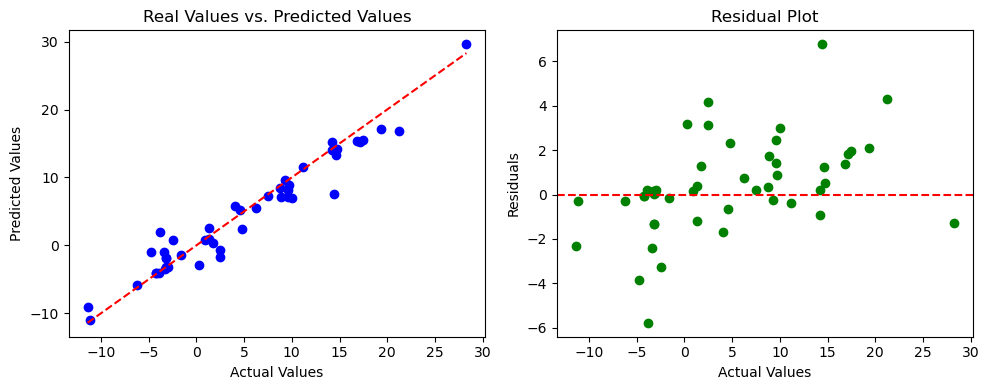

In [23]:
plot_the_r2(y_true=y_test, X_pred = X_test, model = search.best_estimator_ )

Now lets explore the feature importance in this model , we start by getting all the names of the data columns : 

In [39]:
feature_names_ori = df_all_data.drop(['substituent','molecular_formula','Name','canonical_smiles','ΔVC-m','cid','ΔVC -p'],axis=1).columns

Acoording to the documentation : The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [33]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(search.best_estimator_, X_train, y_train, n_jobs=-1,random_state=rng)
sorted_idx = feature_importances.importances_mean.argsort()

We get the names sorted , the feature importance is sorted in ascending value so the best features will be at the end of the list

In [40]:
feature_names = [feature_names_ori[i] for i in sorted_idx]

Thus we can see the name of the top 10 features 

In [48]:
feature_names[-10:]

['tpsa',
 'triple_bond',
 'N',
 'all_atoms_count_unique',
 'F',
 'double_bond',
 'H',
 'σm',
 'Rc',
 'σp']

And we can see the plot , and compare it with the RF Regresor from the vanilla implementation, then make comparison and derive some asumptions 

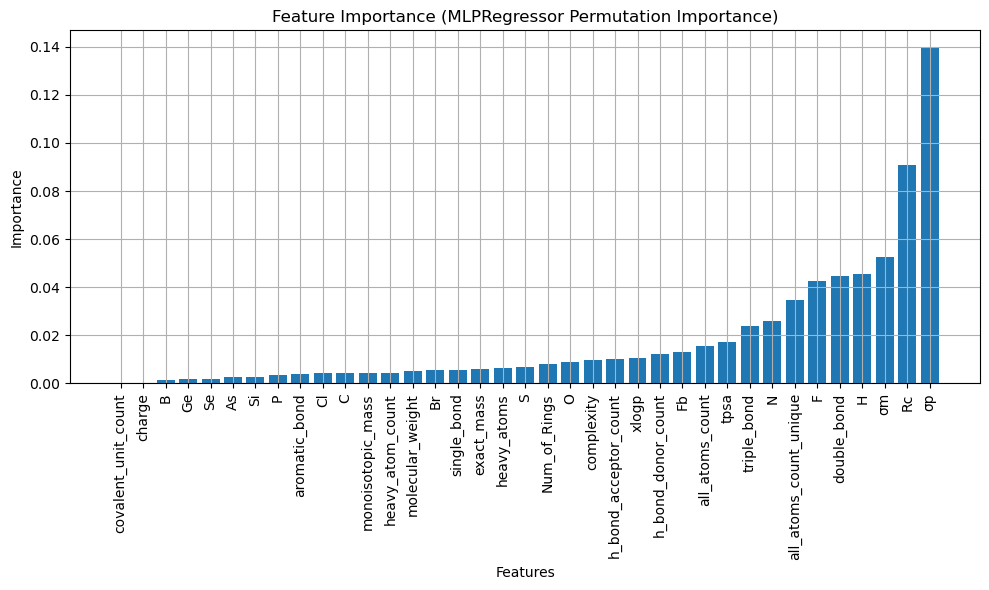

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances.importances_mean[sorted_idx])
plt.grid(True,which="major")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (MLPRegressor Permutation Importance)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.tight_layout()
plt.show()

The following step would be train the MLPRegressor with the minimum number of features and check if the resulting model compites with the best model with all the features . We will use the only ones that have a importance > 0.2 it could be that we lose R^2 we will check the trade off

In [49]:
model_feature_selection = MLPRegressor(alpha=1.5037553212997384e-06, batch_size=64,
             hidden_layer_sizes=(1200, 1200), learning_rate='invscaling')

In [51]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_separated(df_all_data,random_state=rng)
X_train, X_val, X_test = X_train[feature_names[-9:]] , X_val[feature_names[-9:]], X_test[feature_names[-9:]]
X_train, X_val, X_test = scaling_data(X_train, X_val, X_test)

In [52]:
model_feature_selection.fit(X_train,y_train.to_numpy().ravel())

MLPRegressor(alpha=1.5037553212997384e-06, batch_size=64,
             hidden_layer_sizes=(1200, 1200), learning_rate='invscaling')

We then chake the perfromace metrics and we can see there is an actual improvement , the R^2 is higer meanwhile all Errors are lower 

In [54]:
save_metrics_results( y_test= y_test, X_test = X_test, model = model_feature_selection, tag="Feature selected model")

,R^2,MAE,MSE,MAPE,MedAE
Feature selected model,0.96105,1.180281,2.798044,0.333092,0.849741


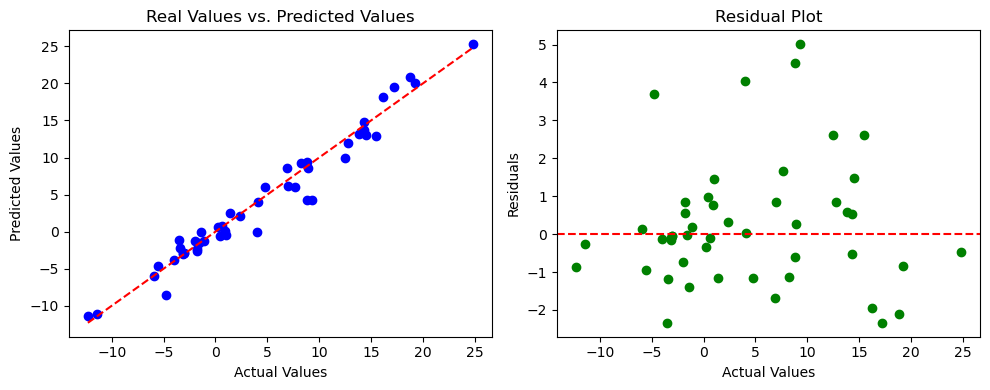

In [55]:
plot_the_r2(y_true=y_test, X_pred = X_test, model = model_feature_selection )